In [ ]:
""" https://nipunbatra.github.io/blog/2017/recommend-keras.html
Recommender Systems in Keras
I have written a few posts earlier about matrix factorisation using 
various Python libraries. The main application I had in mind for matrix 
factorisation was recommender systems. In this post, I'll write about 
using Keras for creating recommender systems. Various people have 
written excellent similar posts and code that I draw a lot of 
inspiration from, and give them their credit! I'm assuming that a reader 
has some experience with Keras, as this post is not intended to be an 
introduction to Keras.

dataset : 
https://grouplens.org/datasets/movielens/100k/

Specifically, in this post, I'll talk about:
1.Matrix Factorisation in Keras
2.Adding non-negativitiy constraints to solve non-negative matrix 
factorisation (NNMF)
3.Using neural networks for recommendations

I'll be using the Movielens-100k dataset for illustration. 
There are 943 users and 1682 movies. In total there are a 100k ratings 
in the dataset. It should be noted that the max. total number of rating 
for the <users, movies> would be 943*1682, which means that we have 
about 7% of the total ratings! All rating are on a scale of 1-5.

Task : 
Given this set of ratings, can we recommend the next set of movies to 
a user? This would translate to: for every user, estimating the ratings 
for all the movies that (s)he hasn't watched and maybe recommend the 
top-k movies by the esimtated ratings! """

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

path = '/Users/USER/Documents/1904_Recommander/ml-100k/'
    
dataset = pd.read_csv(path+'u.data', sep='\t', names="user_id,item_id,rating,timestamp".split(","))
    
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
#  943 users and 1682 movies.
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(943, 1682)

In [9]:
# We assign a unique number between (0, #users) to each user 
# and do the same for movies.
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
dataset.head()

,user_id,item_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [10]:
"""Train test split
We'll now split our dataset of 100k ratings into train 
(containing 80k ratings) and test (containing 20k ratings).
Given the train set, we'd like to accurately estimate the ratings 
in the test set."""
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

train.head()

,user_id,item_id,rating,timestamp
92398,825,567,4,885690636
86154,882,1655,5,891692168
27771,428,11,5,882386424
5480,127,226,2,879968946
62199,830,99,4,891354573


In [11]:
test.head()

,user_id,item_id,rating,timestamp
23757,487,567,3,891294707
45021,197,68,4,884207560
98122,899,409,2,877833326
43946,513,292,3,880209950
72916,558,69,3,891035917


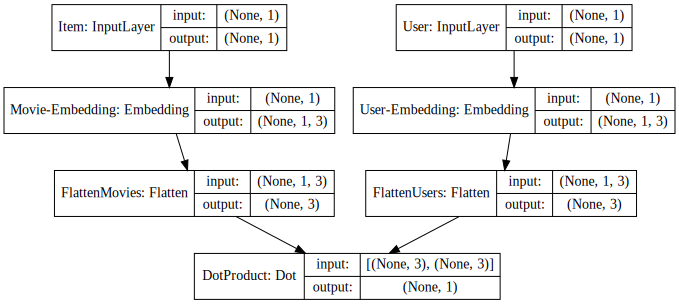

In [24]:
"""Matrix factorisation
One popular recommender systems approach is called Matrix Factorisation.
It works on the principle that we can learn a low-dimensional representation 
(embedding) of user and movie. For example, for each movie, we can have 
how much action it has, how long it is, and so on. For each user, 
we can encode how much they like action, or how much they like long 
movies, etc. Thus, we can combine the user and the movie embeddings 
to estimate the ratings on unseen movies. This approach can also be 
viewed as: given a matrix (A [M X N]) containing users and movies, 
we want to estimate low dimensional matrices (W [M X k] and H [M X k]),
A = W.Ht"""

"""Matrix factorisation in Keras
We'll now write some code to solve the recommendation problem by 
matrix factorisation in Keras. We're trying to learn two 
low-dimensional embeddings of users and items."""

import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.layers import dot  #prod = dot([movie_vec, user_vec], axes=1, normalize=False, name='Dot') 

n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

#prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
#prod = keras.layers.concatenate([movie_vec, user_vec], name='DotProduct')
prod = dot([movie_vec, user_vec], axes=1, normalize=False, name='DotProduct')

model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))


In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [27]:
# epochs = 100
#history = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=1)

# epochs = 20
history = model.fit([train.user_id, train.item_id], train.rating, epochs=20, verbose=1)


Epoch 1/20
80000/80000 [==============================] - 5s 58us/step - loss: 0.8660
Epoch 2/20
80000/80000 [==============================] - 5s 57us/step - loss: 0.8646
Epoch 3/20
80000/80000 [==============================] - 5s 58us/step - loss: 0.8629
Epoch 4/20
80000/80000 [==============================] - 5s 58us/step - loss: 0.8622
Epoch 5/20
80000/80000 [==============================] - 5s 58us/step - loss: 0.8612
Epoch 6/20
80000/80000 [==============================] - 5s 59us/step - loss: 0.8603
Epoch 7/20
80000/80000 [==============================] - 5s 59us/step - loss: 0.8596
Epoch 8/20
80000/80000 [==============================] - 5s 60us/step - loss: 0.8587
Epoch 9/20
80000/80000 [==============================] - 5s 59us/step - loss: 0.8578
Epoch 10/20
80000/80000 [==============================] - 5s 59us/step - loss: 0.8571
Epoch 11/20
80000/80000 [==============================] - 5s 59us/step - loss: 0.8566
Epoch 12/20
80000/80000 [===========================

Text(0, 0.5, 'Train Error')

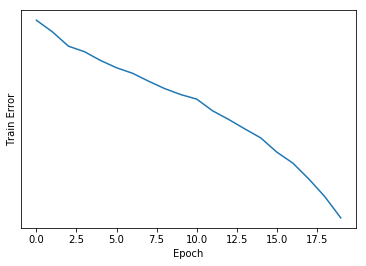

In [28]:
# Train error v/s epoch number
"""Before we test how well our model does in the test setting, 
we can visualise the train loss with epoch number."""
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [29]:
#Prediction error
"""Let's now see how our model does! I'll do a small post-processing step 
to round off our prediction to the nearest integer. 
This is usually not done, and thus just a whimsical step, since the 
training ratings are all integers! There are better ways to encode 
this intger requirement (one-hot encoding!), but we won't discuss 
them in this post."""
y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_true = test.rating

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.7096

In [30]:
"""Not bad! We're able to get a MAE of 0.70! 
I'm sure with a bit of parameter/hyper-parameter optimisation, 
we may be able to improve the results. However, I won't talk about 
these optimisations in this post.

Extracting the learnt embeddings
We can extract the learnt movie and item embeddings as follows:"""
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1683.000000,1683.000000,1683.000000
mean,-0.926217,0.914599,0.936839
std,0.277288,0.260255,0.247297
min,-1.631953,-0.049151,-0.048044
25%,-1.116660,0.762218,0.822029
50%,-0.953397,0.947070,0.974463
75%,-0.762418,1.092644,1.095383
max,0.044245,1.530203,1.519254


In [31]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,944.000000,944.000000,944.000000
mean,-1.145445,1.140592,1.142541
std,0.173725,0.178350,0.200529
min,-1.630783,0.012697,-0.034021
25%,-1.252850,1.028098,1.019345
50%,-1.154652,1.142489,1.148387
75%,-1.045286,1.252090,1.265975
max,-0.028877,1.764431,1.915981


In [34]:
"""We can see that both the user and the item embeddings have negative 
elements. There are some applications which require that the learnt 
embeddings be non-negative. This approach is also called non-negative 
matrix factorisation, which we'll workout now."""

#Non-negative Matrix factorisation (NNMF) in Keras

"""The code for NNMF remains exactly the same as the code for 
matrix factorisation. The only change is that we add non-negativity 
constraints on the learnt embeddings. This is done as follows:"""

from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input))

#prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
prod = dot([movie_vec, user_vec], axes=1, normalize=False, name='DotProduct')

model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

"""We now verify if we are indeed able to learn non-negative embeddings. 
I'll not compare the performance of NNMF on the test set, in the 
interest of space."""
history_nonneg = model.fit([train.user_id, train.item_id], 
                           train.rating, epochs=10, verbose=1)

movie_embedding_learnt = model.get_layer(name='NonNegMovie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

Epoch 1/10
80000/80000 [==============================] - 5s 62us/step - loss: 10.8449
Epoch 2/10
80000/80000 [==============================] - 5s 59us/step - loss: 3.7909
Epoch 3/10
80000/80000 [==============================] - 5s 59us/step - loss: 1.7656
Epoch 4/10
80000/80000 [==============================] - 5s 60us/step - loss: 1.2499
Epoch 5/10
80000/80000 [==============================] - 5s 59us/step - loss: 1.0555
Epoch 6/10
80000/80000 [==============================] - 5s 60us/step - loss: 0.9700
Epoch 7/10
80000/80000 [==============================] - 5s 59us/step - loss: 0.9286
Epoch 8/10
80000/80000 [==============================] - 5s 59us/step - loss: 0.9062
Epoch 9/10
80000/80000 [==============================] - 5s 60us/step - loss: 0.8934
Epoch 10/10
80000/80000 [==============================] - 5s 59us/step - loss: 0.8850


,0,1,2
count,1683.000000,1683.000000,1683.000000
mean,0.841348,0.842675,0.840132
std,0.299351,0.299999,0.299069
min,-0.000000,-0.000000,-0.000000
25%,0.661344,0.663285,0.659532
50%,0.898838,0.901870,0.898603
75%,1.074331,1.072666,1.072875
max,1.385591,1.377312,1.370152


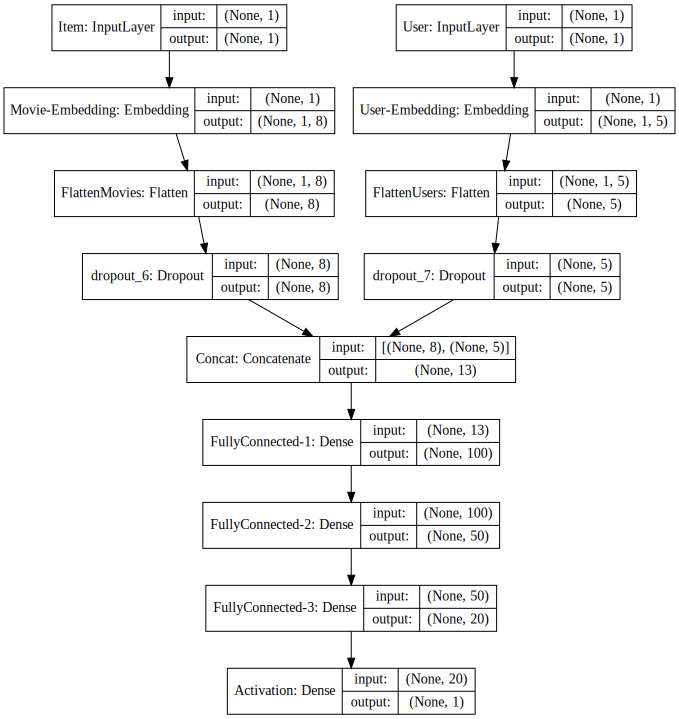

In [37]:
# Neural networks for recommendation
"""We'll now create a simple neural network for recommendation, or 
for estimating rating! This model is very similar to the earlier 
matrix factorisation models, but differs in the following ways:

1. Instead of taking a dot product of the user and the item embedding,
we concatenate them and use them as features for our neural network. 
Thus, we are not constrained to the dot product way of combining the 
embeddings, and can learn complex non-linear relationships.

2. Due to #1, we can now have a different dimension of user and 
item embeddings. This can be useful if one dimension is larger than 
the other."""

n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)

#concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
concat = keras.layers.concatenate([movie_vec, user_vec], name='Concat')

concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss='mean_absolute_error')

SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))


In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         13464       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [40]:
"""We can see that the number of parameters is more than what 
we had in the Matrix Factorisation case. 
Let's see how this model works. 
I'll run it for more epochs given that we have more parameters."""

# history = model.fit([train.user_id, train.item_id], 
#                     train.rating, epochs=250, verbose=1)

history = model.fit([train.user_id, train.item_id], 
                    train.rating, epochs=25, verbose=1)


Epoch 1/25
80000/80000 [==============================] - 7s 92us/step - loss: 0.7598
Epoch 2/25
80000/80000 [==============================] - 7s 92us/step - loss: 0.7527
Epoch 3/25
80000/80000 [==============================] - 7s 91us/step - loss: 0.7446
Epoch 4/25
80000/80000 [==============================] - 7s 92us/step - loss: 0.7329
Epoch 5/25
80000/80000 [==============================] - 7s 92us/step - loss: 0.7263
Epoch 6/25
80000/80000 [==============================] - 7s 93us/step - loss: 0.7238
Epoch 7/25
80000/80000 [==============================] - 7s 93us/step - loss: 0.7197
Epoch 8/25
80000/80000 [==============================] - 7s 92us/step - loss: 0.7160
Epoch 9/25
80000/80000 [==============================] - 7s 92us/step - loss: 0.7106
Epoch 10/25
80000/80000 [==============================] - 7s 91us/step - loss: 0.7056
Epoch 11/25
80000/80000 [==============================] - 7s 91us/step - loss: 0.7049
Epoch 12/25
80000/80000 [===========================

In [41]:
# Prediction performance of Neural Network based recommender system
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])))

0.69665
0.7093682453036309


In [ ]:
"""Pretty similar to the result we got using matrix factorisation. 
Maybe, we need to tweak around a lot more with the neural network to
get better results?

Thanks for reading. This post has been a good learning experience 
for me. Hope you enjoyed too!"""